# GradCAM - Gradient Class Activation Map

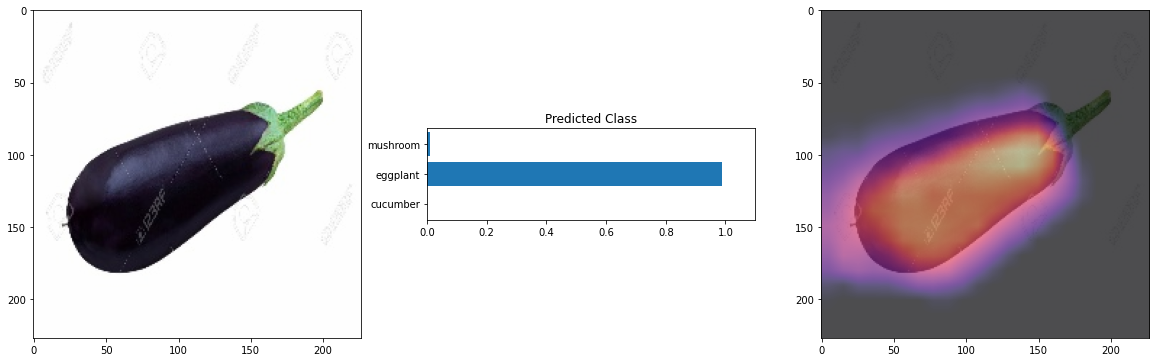

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 27.31 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-c5_2vttp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-c5_2vttp
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=d9510886ee4d0793efe9bdb957cae8073033b722a69b0f43da8c4c4dc1727044
  Stored in directory: /tmp/pip-ephem-whee

# Imports

In [2]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [6]:
data = pd.read_csv(CSV_FILE)
data

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1
...,...,...
181,train_images/eggplant_62.jpg,1
182,train_images/cucumber_45.jpg,0
183,train_images/mushroom_37.jpg,2
184,train_images/eggplant_44.jpg,1


In [7]:
# Label: cucumber - 0, eggplant - 1, mushroom - 2
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)


# Augmentations

In [8]:
train_augs = A.Compose([
      A.Rotate(),
      A.HorizontalFlip(0.5),
      A.VerticalFlip(0.5),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_augs = A.Compose([
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Image Dataset 

In [9]:
class ImageDataset(Dataset):

    def __init__(self, df, data_dir = None, augs = None,):
        self.df = df
        self.augs = augs
        self.data_dir = data_dir 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = self.data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = row.label 

        if self.augs:
            data = self.augs(image = img)
            img = data['image']

        img = torch.from_numpy(img).permute(2, 0, 1)

        return img, label

In [10]:
trainset = ImageDataset(df=train_df, augs=train_augs, data_dir=DATA_DIR)
validset = ImageDataset(df=valid_df, augs=valid_augs, data_dir=DATA_DIR)

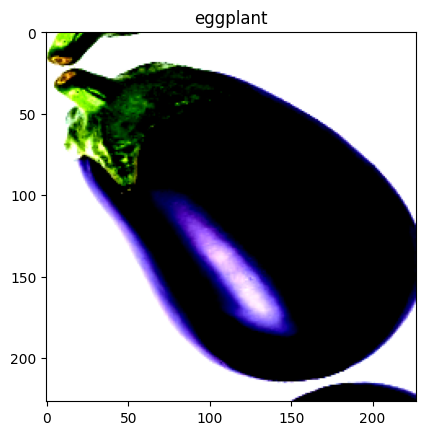

In [11]:
image, label = trainset[5]  # image in Torch.Tensor, shape=(c, h, w)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [12]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [16]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [18]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model 

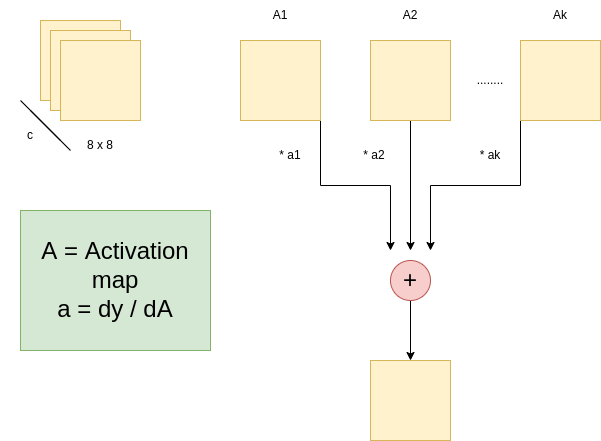


The `activations_hook` method is used to register a hook on the feature extractor's output tensor. This hook will be called every time the tensor is calculated during the forward pass. The hook saves the gradient of the tensor, which can be used to calculate the gradient of the loss with respect to the feature extractor's output.


In PyTorch, a hook is a function that can be registered to be called when a certain event happens during the forward or backward pass of a neural network. In this case, the `activations_hook` is registered to be called every time the feature extractor's output tensor `x` is calculated during the forward pass of the `ImageModel`. 

The `activations_hook` method takes the gradient of the tensor `x` as an input and saves it to the `gradient` attribute of the `ImageModel` object. This gradient will be used later to calculate the gradient of the loss with respect to the feature extractor's output.

The purpose of using an activation hook is to capture the activations of the feature extractor's output tensor during the forward pass. These activations can be used for various purposes, such as visualizing the activations of the network, or calculating the gradient of the loss with respect to the activations. 

For example, in the case of visualizing the activations, the activations hook can be used to extract the feature maps of the network for a given input image. These feature maps can be visualized to gain insights into what the network is learning at different layers of the network.

In [19]:
class ImageModel(nn.Module):
  def __init__(self) -> None:
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
    )
    self.gradient = None
  
  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)  # use as activation maps -> multiply weights(*a1) w/ activation maps
    
    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)
    return x
  
  def get_activation_gradients(self): # return gradient a1, a2, ..., ak
    return self.gradient
  
  def get_activation(self, x):  # return activation A1, A2, ..., Ak
    return self.feature_extractor(x)  # shape=(64, 8, 8) as (c, h, w)

In [20]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [21]:
def train_fn(dataloader: DataLoader, model: ImageModel, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)  # no activation
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [22]:
def eval_fn(dataloader: DataLoader, model: ImageModel, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = model(images)  # no activation
    loss = criterion(logits, labels)

    total_loss += loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [23]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('SAVE_WEIGHT_SUCCESS')
  
  print(f'EPOCH: {i+1} \t TRAIN_LOSS: {train_loss} \t VALID_LOSS: {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 32.55it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 1 	 TRAIN_LOSS: 1.2239496648311614 	 VALID_LOSS: 0.9201953411102295


100%|██████████| 3/3 [00:00<00:00, 23.95it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 2 	 TRAIN_LOSS: 0.7311417132616043 	 VALID_LOSS: 0.5792575776576996


100%|██████████| 3/3 [00:00<00:00, 24.53it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 3 	 TRAIN_LOSS: 0.537759518623352 	 VALID_LOSS: 0.37096020579338074


100%|██████████| 3/3 [00:00<00:00, 32.29it/s]


EPOCH: 4 	 TRAIN_LOSS: 0.3455273635685444 	 VALID_LOSS: 0.5440900127092997


100%|██████████| 3/3 [00:00<00:00, 34.25it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 5 	 TRAIN_LOSS: 0.17040083166211845 	 VALID_LOSS: 0.21913290147980055


100%|██████████| 3/3 [00:00<00:00, 34.06it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 6 	 TRAIN_LOSS: 0.5305770881474018 	 VALID_LOSS: 0.126321313281854


100%|██████████| 3/3 [00:00<00:00, 33.64it/s]


EPOCH: 7 	 TRAIN_LOSS: 0.20991542860865592 	 VALID_LOSS: 0.3266177574793498


100%|██████████| 3/3 [00:00<00:00, 35.75it/s]


EPOCH: 8 	 TRAIN_LOSS: 0.10086122881621122 	 VALID_LOSS: 0.2473572719221314


100%|██████████| 3/3 [00:00<00:00, 34.43it/s]


EPOCH: 9 	 TRAIN_LOSS: 0.11702776812016964 	 VALID_LOSS: 0.6890327055007219


100%|██████████| 3/3 [00:00<00:00, 35.39it/s]


EPOCH: 10 	 TRAIN_LOSS: 0.23932212367653846 	 VALID_LOSS: 0.36022883327677846


100%|██████████| 3/3 [00:00<00:00, 28.60it/s]


EPOCH: 11 	 TRAIN_LOSS: 0.10082378014922141 	 VALID_LOSS: 0.3214867102603118


100%|██████████| 3/3 [00:00<00:00, 32.61it/s]


EPOCH: 12 	 TRAIN_LOSS: 0.1355759460653644 	 VALID_LOSS: 0.33322168948749703


100%|██████████| 3/3 [00:00<00:00, 33.69it/s]


EPOCH: 13 	 TRAIN_LOSS: 0.21111548850312828 	 VALID_LOSS: 0.6180391361316045


100%|██████████| 3/3 [00:00<00:00, 33.03it/s]


EPOCH: 14 	 TRAIN_LOSS: 0.1192257141461596 	 VALID_LOSS: 0.12809156067669392


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


EPOCH: 15 	 TRAIN_LOSS: 0.07402344802540028 	 VALID_LOSS: 0.32086756949623424


100%|██████████| 3/3 [00:00<00:00, 19.42it/s]


EPOCH: 16 	 TRAIN_LOSS: 0.06344842484686523 	 VALID_LOSS: 0.21469186494747797


100%|██████████| 3/3 [00:00<00:00, 35.10it/s]


EPOCH: 17 	 TRAIN_LOSS: 0.01914370454614982 	 VALID_LOSS: 0.41575025386797887


100%|██████████| 3/3 [00:00<00:00, 24.52it/s]


EPOCH: 18 	 TRAIN_LOSS: 0.06490809444367188 	 VALID_LOSS: 0.13042077123342702


100%|██████████| 3/3 [00:00<00:00, 23.79it/s]


EPOCH: 19 	 TRAIN_LOSS: 0.014735806875978596 	 VALID_LOSS: 0.246158964796147


100%|██████████| 3/3 [00:00<00:00, 24.53it/s]

EPOCH: 20 	 TRAIN_LOSS: 0.003502393391681835 	 VALID_LOSS: 0.30841616870990646


# Get GradCAM

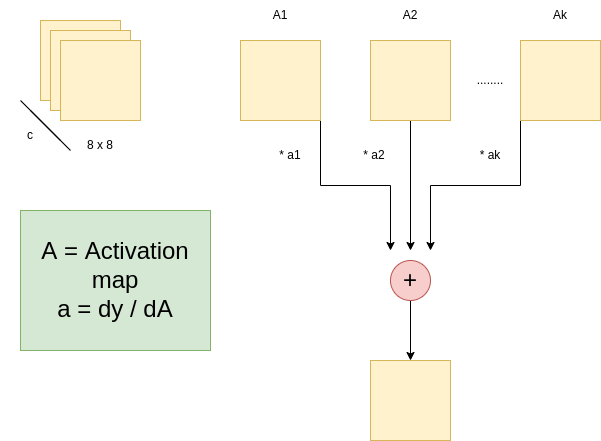

In [25]:
def get_grad_cam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=(0, 2, 3)) # get gradient weights: a1, a2, ..., ak
  activations = model.get_activation(image).detach()  # get activation map: A1, A2, ..., Ak
  
  for i in range(activations.shape[1]): # number of channel
    activations[:, i, :, :] *= pooled_gradients[i]
  
  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

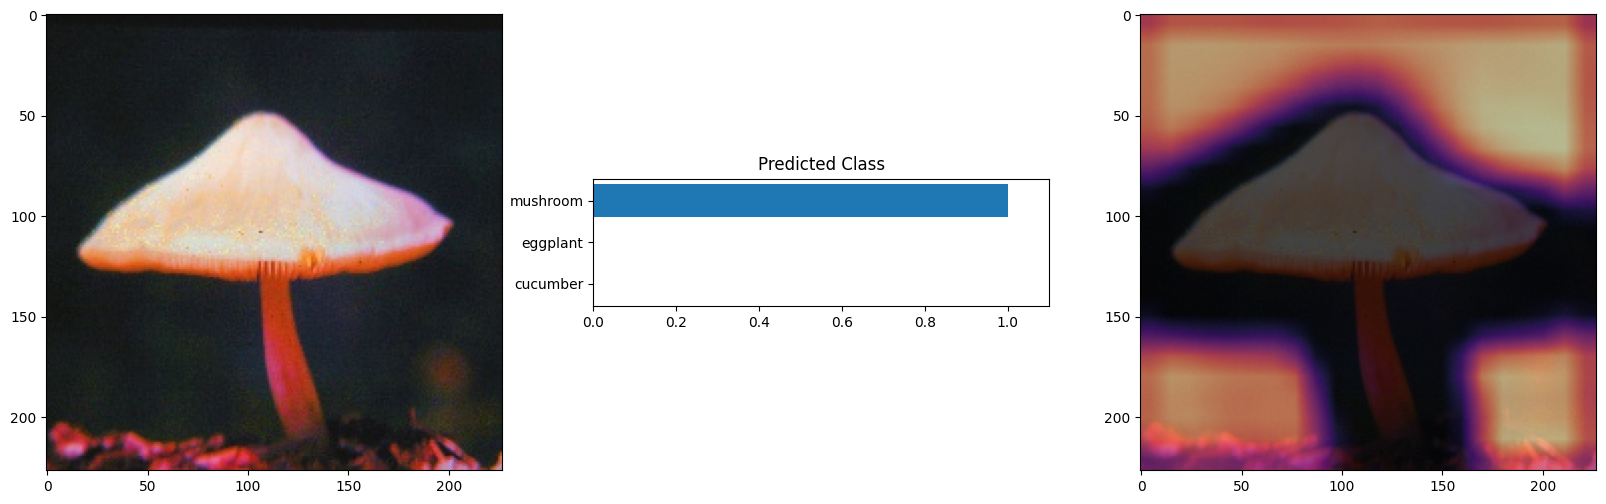

In [27]:
image, label = validset[5]

denorm_img = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
# Label: cucumber - 0, eggplant - 1, mushroom - 2
# pred[0] returns label list, pred[0][1] is eggplant
heatmap = get_grad_cam(model, image, pred[0][1], size=227)  
utils.plot_heatmap(denorm_img, pred, heatmap)